# 1. Setup

In [ ]:
import sys
from pathlib import Path
sys.path.append(str(Path().resolve().parent))

In [ ]:
# Horizontal Scrolling
import io
import base64
from IPython.display import HTML, display

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mt
# import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from pandas import DataFrame #, Series, Timedelta
# from scipy.ndimage import binary_dilation
from sklearn.metrics import mean_absolute_error as MAE

In [ ]:
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor # early_stopping, log_evaluation
from xgboost import XGBRegressor

In [ ]:
from utils.loading import load_all_raw_data
from utils.preprocessing import process_all_dfs
from utils.merging import merge_all_dfs
from utils.feature_engineering import *

In [ ]:
pd.set_option(
    "display.float_format",
    lambda x: f"{x:.2e}" if abs(x) < 0.01 and x != 0 else f"{x:.2f}",
)
pd.set_option('display.max_columns', 100)
pd.set_option("display.max_rows", 100)

In [ ]:
RAW_DATA_PATH = "../data/raw_data/"
ADDITIONAL_DATA_PATH = "../data/additional_data/"

SEGMENT_C = ["county", "product_type", "is_business"]
CATEGORICAL_C = ["county", "product_type", "is_business", "is_consumption"]
TARGET_C = [
    "county",
    "product_type",
    "is_business",
    "is_consumption",
    "datetime",
]
RAND = 10

# 2. Data Preparation

In [ ]:
processed_dfs = process_all_dfs(
    load_all_raw_data(RAW_DATA_PATH, ADDITIONAL_DATA_PATH)
)

# processed_dfs.keys()
df = merge_all_dfs(processed_dfs, how="left")
df = add_dst_flag(df)
df = add_cyclic_datetime_features(df, drop_raw=True)

In [ ]:
for lag in [2, 3, 7]:
# for lag in range(2, 15):
    df = df.merge(
        get_lag(processed_dfs["train"][TARGET_C + ["target"]], lag=lag),
        how="left",
        on=TARGET_C,
    )

In [ ]:
for window in [24, 24 * 3, 24 * 7, 24 * 14]:
    # for window in [24 * i for i in range(1, 15)]:
    df = df.merge(
        get_moving_average(
            processed_dfs["train"]
            .set_index("datetime")
            .sort_index()
            .groupby(CATEGORICAL_C, observed=True, as_index=False),
            columns=["target"],
            window=window,
            # ).dropna(),
        ),
        how="left",
        on=TARGET_C,
    )

In [ ]:
df["t_over_cap"] = (df["2d_lag_target"] / df["installed_capacity"]).astype(
    "float32"
)
df["t_over_eic"] = (df["2d_lag_target"] / df["eic_count"]).astype("float32")
df["cap_per_eic"] = (df["installed_capacity"] / df["eic_count"]).astype(
    "float32"
)

# 3. Baselines Comparison

## Train-Test Splits

In [ ]:
FEATURES_TO_DROP = ["datetime", "data_block_id", "date"]

In [ ]:
print(
    f"First timestamp: {df["datetime"].min()}",
    f"Last timestamp: {df["datetime"].max()}",
    sep="\n"
)

First timestamp: 2021-09-01 00:00:00
Last timestamp: 2023-05-31 23:00:00


In [ ]:
# df["datetime"].is_monotonic_increasing
# df = df.sort_values('datetime', ignore_index=True)

In [ ]:
start_ts = df["datetime"].min()
splits = get_month_splits(start_ts, 17, 1, 1, 4)
splits

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-01-31 23:00:00')),
  'test': (Timestamp('2023-02-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00')),
  'test': (Timestamp('2023-03-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00')),
  'test': (Timestamp('2023-04-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00')),
  'test': (Timestamp('2023-05-01 00:00:00'),
   Timestamp('2023-05-31 23:00:00'))}]

## Models Training

In [ ]:
cat_cols = df.select_dtypes(include="category").columns.tolist()
scores = {}
(
    naive_mae,
    xgb_mae_history,
    lgbm_mae_history,
    cb_mae_history,
) = (
    [],
    [],
    [],
    [],
)

xgb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "reg:absoluteerror",
    "enable_categorical": True,
    "eval_metric": "mae",
    "n_jobs": -1,
}
lgbm_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "objective": "regression_l1",
    "metric": "mae",
    "n_jobs": -1,
    "force_col_wise": True,
    "verbosity": -1,
}
cb_p = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 7,
    "random_state": RAND,
    "subsample": 0.8,
    "colsample_bylevel": 0.8,
    "loss_function": "MAE",
    "cat_features": cat_cols,
    "eval_metric": "MAE",
    "thread_count": -1,
    "verbose": False,
}

for i, split in enumerate(splits):
    df_train = df[
        (df["datetime"] >= split["train"][0])
        & (df["datetime"] <= split["train"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_train, y_train = (
        df_train.drop(["target"], axis=1),
        df_train["target"],
    )

    df_test = df[
        (df["datetime"] >= split["test"][0])
        & (df["datetime"] <= split["test"][1])
    ].drop(FEATURES_TO_DROP, axis=1)

    X_test, y_test = (
        df_test.drop(["target"], axis=1),
        df_test["target"],
    )
    scores[i] = {}

    # Naive baseline
    scores[i]["Naive"] = MAE(
        y_test.loc[X_test["2d_lag_target"].notna()],
        X_test["2d_lag_target"].dropna(),
    )

    eval_set = [(X_train, y_train)]

    for model_name, model_cls, model_params in [
        ("XGB", XGBRegressor, xgb_p),
        ("LGBM", LGBMRegressor, lgbm_p),
        ("CB", CatBoostRegressor, cb_p),
    ]:
        model = model_cls(**model_params)

        if isinstance(model, XGBRegressor):
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                verbose=0,
            )
            xgb_mae_history.append(model.evals_result())

        elif isinstance(model, LGBMRegressor):
            model.fit(
                X_train,
                y_train,
                categorical_feature=cat_cols,
                eval_set=eval_set,
            )
            lgbm_mae_history.append(model.evals_result_)

        else:
            model.fit(
                X_train,
                y_train,
                eval_set=eval_set,
                cat_features=cat_cols,
            )
            cb_mae_history.append(model.evals_result_)
        scores[i][model_name] = MAE(y_test, model.predict(X_test))

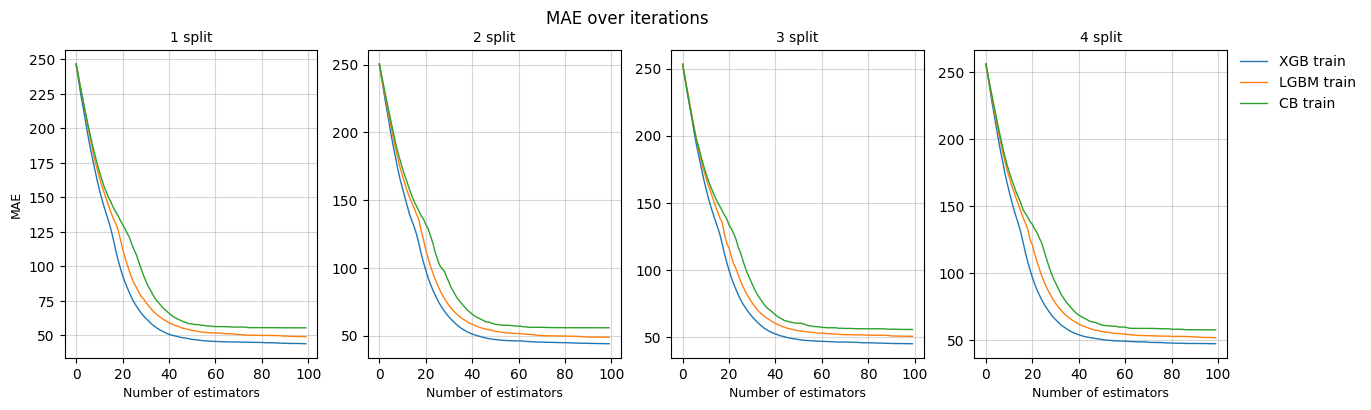

In [ ]:
total_splits = len(splits)
rows, cols = 1, total_splits
fig, axs = plt.subplots(rows, cols, figsize=(15, 4))
axs = axs.flatten()

for split_i in range(total_splits):
    ax = axs[split_i]
    ax.plot(
        xgb_mae_history[split_i]["validation_0"]["mae"],
        "C0",
        label=f"XGB train",
        lw=1,
    )
    ax.plot(
        lgbm_mae_history[split_i]["training"]["l1"],
        "C1",
        label=f"LGBM train",
        lw=1,
    )
    ax.plot(
        cb_mae_history[split_i]["learn"]["MAE"],
        "C2",
        label=f"CB train",
        lw=1,
    )
    if split_i >= total_splits - cols:
        ax.set_xlabel("Number of estimators", size=9)
    if split_i in [i * cols for i in range(rows)]:
        ax.set_ylabel("MAE", size=9)
    ax.set_title(f"{split_i + 1} split", size=10)
    ax.grid(which="both", alpha=0.5)
    # ax.set_yscale("log")

plt.legend(
    loc="upper left",
    bbox_to_anchor=(1, 1.025),
    frameon=False,
)
fig.suptitle(
    "MAE over iterations",
    # y=1.0125,
    fontsize=12,
)
# plt.tight_layout()

plt.show()

In [ ]:
scores_df = DataFrame(scores).reset_index(names="model")
scores_df

,model,0,1,2,3
0,Naive,75.59,99.54,127.00,122.23
1,XGB,44.22,68.76,84.81,90.65
2,LGBM,49.49,73.58,90.45,95.52
3,CB,58.41,81.80,93.70,102.26


In [ ]:
scores_df_long = scores_df.melt(id_vars="model", var_name="split", value_name="MAE")
scores_df_long

,model,split,MAE
0,Naive,0,75.59
1,XGB,0,44.22
2,LGBM,0,49.49
3,CB,0,58.41
4,Naive,1,99.54
5,XGB,1,68.76
6,LGBM,1,73.58
7,CB,1,81.80
8,Naive,2,127.00
9,XGB,2,84.81


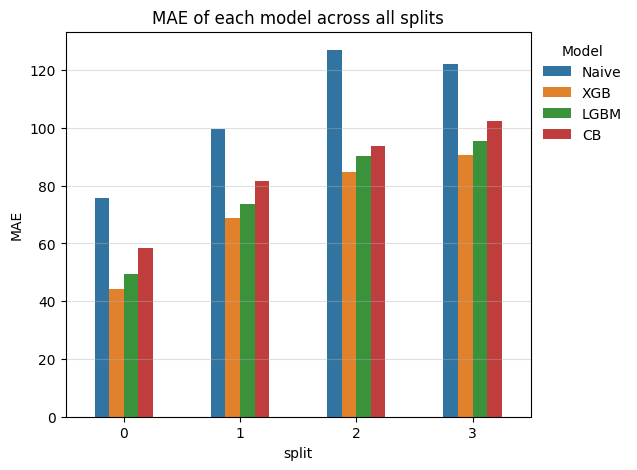

In [ ]:
plt.figure(figsize=(6, 5))
sns.barplot(
    data=scores_df_long,
    x="split",
    y="MAE",
    hue="model",
    errorbar=None,
    dodge=True,
    width=0.5,
)
plt.title("MAE of each model across all splits")
plt.grid(True, axis="y", alpha=0.4)
plt.legend(
    title="Model",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
plt.show()

The XGBoost baseline shows the best results while the LightGBM baseline performs slightly worse. The gap with the CatBoost baseline is more significant, and XGBoost clearly outperforms the naive baseline.

In [ ]:
scores_df["mean_mae"] = scores_df.iloc[:, 1:].mean(axis=1)
scores_df

,model,0,1,2,3,mean_mae
0,Naive,75.59,99.54,127.00,122.23,106.09
1,XGB,44.22,68.76,84.81,90.65,72.11
2,LGBM,49.49,73.58,90.45,95.52,77.26
3,CB,58.41,81.80,93.70,102.26,84.04


On the test data for all months, XGBoost also shows the best results.

## Separate Models for Consumption and Production

In the first notebook, it was verified that for each combination of `datetime`, `county`, `product_type`, and `is_business`, there is exactly one consumption and one production value (i.e., no class imbalance in this regard). It was also shown that while there are some similarities between the two target types, there are also notable differences. Therefore, it may be beneficial to train separate models for each target type.

In [ ]:
splits

[{'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-01-31 23:00:00')),
  'test': (Timestamp('2023-02-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-02-28 23:00:00')),
  'test': (Timestamp('2023-03-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-03-31 23:00:00')),
  'test': (Timestamp('2023-04-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00'))},
 {'train': (Timestamp('2021-09-01 00:00:00'),
   Timestamp('2023-04-30 23:00:00')),
  'test': (Timestamp('2023-05-01 00:00:00'),
   Timestamp('2023-05-31 23:00:00'))}]

In [ ]:
scores_pc = {}

for i, split in enumerate(splits):
    scores_pc[i] = {}
    for is_cons in [False, True]:
        df_train = df[
            (df["datetime"] >= split["train"][0])
            & (df["datetime"] <= split["train"][1])
            & (df["is_consumption"]== is_cons)
        ].drop(FEATURES_TO_DROP, axis=1)
    
        X_train, y_train = (
            df_train.drop(["target"], axis=1),
            df_train["target"],
        )
    
        df_test = df[
            (df["datetime"] >= split["test"][0])
            & (df["datetime"] <= split["test"][1])
            & (df["is_consumption"]== is_cons)
        ].drop(FEATURES_TO_DROP, axis=1)
    
        X_test, y_test = (
            df_test.drop(["target"], axis=1),
            df_test["target"],
        )
        scores_pc[i][is_cons] = {}
    
        # Naive baseline
        scores_pc[i][is_cons]["Naive"] = MAE(
            y_test.loc[X_test["2d_lag_target"].notna()],
            X_test["2d_lag_target"].dropna(),
        )
    
        eval_set = [(X_train, y_train)]
    
        for model_name, model_cls, model_params in [
            ("XGB", XGBRegressor, xgb_p),
            ("LGBM", LGBMRegressor, lgbm_p),
            ("CB", CatBoostRegressor, cb_p),
        ]:
            model = model_cls(**model_params)
    
            if isinstance(model, XGBRegressor):
                model.fit(
                    X_train,
                    y_train,
                    verbose=0,
                )
            elif isinstance(model, LGBMRegressor):
                model.fit(
                    X_train,
                    y_train,
                    categorical_feature=cat_cols,
                )
            else:
                model.fit(
                    X_train,
                    y_train,
                    cat_features=cat_cols,
                )
            scores_pc[i][is_cons][model_name] = MAE(y_test, model.predict(X_test))

In [ ]:
records = []

for split, cons_dict in scores_pc.items():
    for is_cons, model_dict in cons_dict.items():
        for model, mae in model_dict.items():
            records.append({
                "split": split,
                "is_consumption": is_cons,
                "model": model,
                "mae": mae,
            })

scores_pc_df = pd.DataFrame(records)
scores_pc_df

,split,is_consumption,model,mae
0,0,False,Naive,21.23
1,0,False,XGB,12.36
2,0,False,LGBM,12.52
3,0,False,CB,13.11
4,0,True,Naive,129.96
5,0,True,XGB,66.53
6,0,True,LGBM,68.78
7,0,True,CB,77.84
8,1,False,Naive,67.57
9,1,False,XGB,38.70


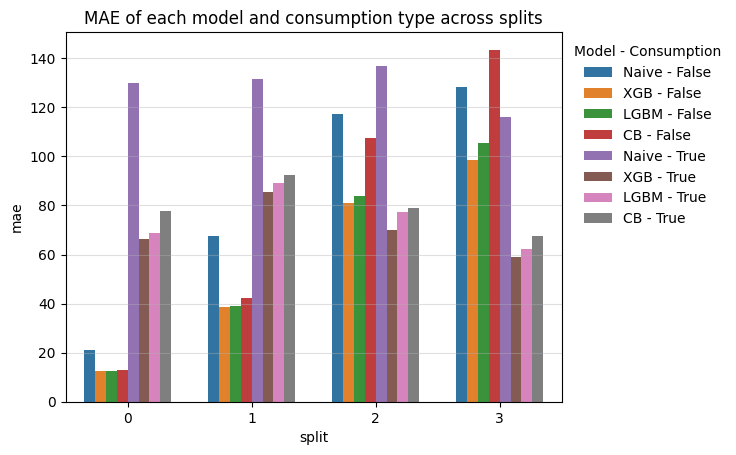

In [ ]:
scores_pc_df["model_consumption"] = (
    scores_pc_df["model"] + " - " + scores_pc_df["is_consumption"].astype(str)
)

sns.barplot(
    data=scores_pc_df,
    x="split",
    y="mae",
    hue="model_consumption",
    dodge=True,
    errorbar=None,
    width=0.7,
)

plt.title("MAE of each model and consumption type across splits")
plt.grid(True, axis="y", alpha=0.4)
plt.legend(
    title="Model - Consumption",
    loc="upper left",
    bbox_to_anchor=(1, 1),
    frameon=False,
)
plt.show()

In [ ]:
scores_pc_df.groupby(["model_consumption"], as_index=False)[["mae"]].mean()

,model_consumption,mae
0,CB - False,76.65
1,CB - True,79.25
2,LGBM - False,60.12
3,LGBM - True,74.40
4,Naive - False,83.60
5,Naive - True,128.58
6,XGB - False,57.61
7,XGB - True,70.32


In [ ]:
scores_df

,model,0,1,2,3,mean_mae
0,Naive,75.59,99.54,127.00,122.23,106.09
1,XGB,44.22,68.76,84.81,90.65,72.11
2,LGBM,49.49,73.58,90.45,95.52,77.26
3,CB,58.41,81.80,93.70,102.26,84.04


On average, the two-model approach achieves a lower monthly MAE compared to the single-model alternative.

## Fixed vs Expanding Splits